In [14]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib qt

In [15]:
seed = 0
tf.reset_default_graph()
tf.random.set_random_seed(seed)
np.random.seed(seed)

x = tf.placeholder(dtype=tf.float32, shape=[None,2])

w1 = tf.Variable(np.random.normal(scale=np.sqrt(2./2),size=[2,512]).astype(np.float32))
b1 = tf.Variable(np.zeros(512,dtype=np.float32))
w2 = tf.Variable(np.random.normal(scale=np.sqrt(2./512),size=[512,512]).astype(np.float32))
b2 = tf.Variable(np.zeros(512,dtype=np.float32))
w3 = tf.Variable(np.random.normal(scale=np.sqrt(2./512),size=[512,1]).astype(np.float32))
b3 = tf.Variable(np.zeros(1,dtype=np.float32))

params = [w1,b1,w2,b2,w3,b3]
nr_params = sum([np.prod(p.get_shape().as_list()) for p in params])
scaling = 2**125
scaling = 2**126

def get_logits(par):
    h1 = tf.nn.bias_add(tf.matmul(x , par[0]), par[1]) / scaling
    h2 = tf.nn.bias_add(tf.matmul(h1, par[2]) , par[3] / scaling)   
    o =   tf.nn.bias_add(tf.matmul(h2, par[4]), par[5] / scaling)*scaling
    return o
    
def get_logits_non(par):
    h1 = tf.nn.relu( tf.nn.bias_add(tf.matmul(x , par[0]), par[1]) )
    h2 = tf.nn.relu( tf.nn.bias_add(tf.matmul(h1, par[2]) , par[3]))   
    o =   tf.nn.bias_add(tf.matmul(h2, par[4]), par[5] )
    return o
    
output = get_logits(params)
output_nonlin = get_logits_non(params)

In [16]:
grid = 1000

# plt.figure(figsize = (40,20))

c = 0
ins = np.zeros((grid*grid, 2) )

x_space = np.linspace(-0.5, 0.5, 1000)
y_space = np.linspace(-0.5, 0.5, 1000)
for x_val in range(grid):
  for y_val in range(grid):
    j = [x_val*1.0/grid-0.5, y_val*1.0/grid-0.5]
    n = [round(x_space[x_val], 3), round(y_space[y_val], 3)]
    # print(j, n)
    ins[c] = n
    # ins[c] = [x_val, y_val]
    c+= 1

print(ins)

rescale = 30
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    vals = sess.run(output, {x: ins * rescale})
    vals_2 = sess.run(output_nonlin, {x: ins * rescale})


outs = np.zeros((grid, grid) )
outs_2 = np.zeros((grid, grid) )

c = 0
for x_val in range(grid):
  for y_val in range(grid):
    outs[x_val, y_val] = vals[c]
    outs_2[x_val, y_val] = vals_2[c]
    c+= 1


[[-0.5   -0.5  ]
 [-0.5   -0.499]
 [-0.5   -0.498]
 ...
 [ 0.5    0.498]
 [ 0.5    0.499]
 [ 0.5    0.5  ]]


<IPython.core.display.Javascript object>


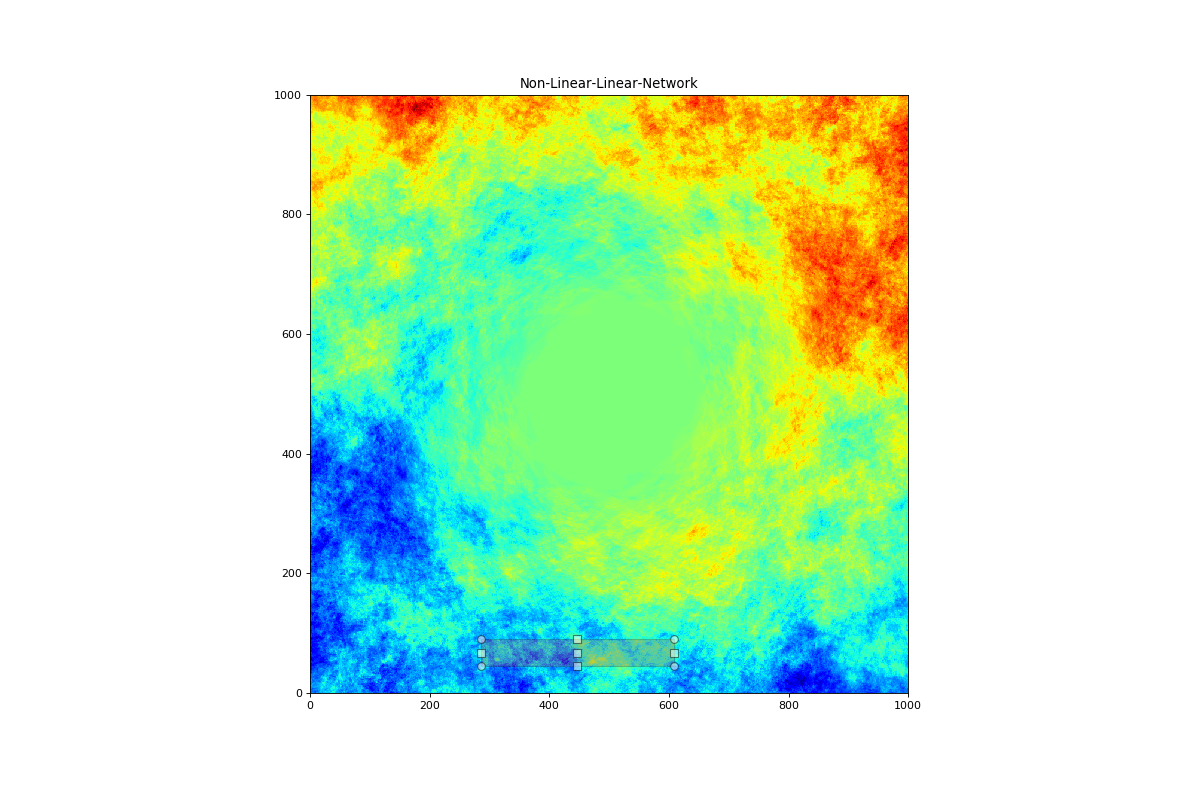

In [17]:
from matplotlib.widgets  import RectangleSelector
%matplotlib qt
# fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 15))
# plt.subplot(1,2, 1)
fig, ax = plt.subplots(figsize=(15, 10))
# line, = ax.plot(xdata, ydata)
ax.imshow(outs.T, origin='lower', cmap='jet')
ax.set_title( 'Non-Linear-Linear-Network')

# ax2.imshow(outs.T, origin="lower", cmap="jet")

# plt.subplot(1,2, 2)
# plt.imshow(outs_2.T, origin='lower', cmap='jet')
# plt.title( 'DNN')
#plt.show()
global corners

def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    rect = plt.Rectangle( (min(x1,x2),min(y1,y2)), np.abs(x1-x2), np.abs(y1-y2) )
    corners = (min(x1, x2), min(y1, y2), np.abs(x1-x2), np.abs(y1-y2))

    grid = 1000

    x_min = corners[0]
    x_max = corners[2]
    y_min = corners[1]
    y_max = corners[3]
    
    c = 0
    ins = np.zeros((grid*grid, 2) )
    x_space = np.linspace(x_min, x_max, 1000)
    y_space = np.linspace(y_min, y_max, 1000)
    for x_val in x_space:
      for y_val in y_space:
        ins[c] = [round(x_val, 3), round(y_val, 3)]
        c+= 1
    
    print(ins.shape)

    rescale = 0.3
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        vals = sess.run(output, {x: ins * rescale})


    outs = np.zeros((grid, grid) )

    c = 0
    for x_val in range(grid):
      for y_val in range(grid):
        outs[x_val, y_val] = vals[c]
        c+= 1

    # ax.set_xlim([x_min, x_max])
    # ax.set_ylim([y_min, y_max])
    ax.imshow(outs.T, origin="lower", cmap="jet")




rs = RectangleSelector(ax, line_select_callback,
                       drawtype='box', useblit=False, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)

plt.show() 

In [14]:
ins[0]

array([-0.5, -0.5])